In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
# tf.random.set_seed(123)
# np.random.seed(123)
from sklearn import metrics
import json 
import os

def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print(f'MSE is : {mse}')
    print(f'MAE is : {mae}')
    print(f'RMSE is : {rmse}')
    print(f'MAPE is : {mape}')
    print(f'R2 is : {r2}',end='\n\n')
    return {'mse' : mse, 'mae' : mae, 'rmse' : rmse, 'mape' : mape, 'r2' : r2}
    
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

# df = pd.read_csv(r'..\Data\Panama Electricity\continuous_dataset_preprocessing.csv', parse_dates= True)
df = pd.read_csv(
    "/Users/trungnguyen/Desktop/cttn-khmt-k64/deep learning/project/DL_HUST_Project/Data/Panama Electricity/continuous_dataset_preprocessing.csv",
    parse_dates=True,
)

df["datetime"] = df["datetime"].apply(pd.to_datetime)

column_names = df.columns.tolist()
train_column_names = df.columns.tolist()
column_names.remove('datetime')
train_column_names.remove('datetime')
train_column_names.remove('nat_demand')

In [8]:
valid = df[df['datetime'] <= '1/1/2019 23:00']
valid = valid[valid['datetime'] > '1/1/2018 23:00']
train = df[df['datetime'] <= '1/1/2018 23:00']
test = df[df['datetime'] > '1/1/2019 23:00']

# train['nat_demand'] = train['nat_demand'].clip(lower = 500)
# valid['nat_demand'] = valid['nat_demand'].clip(lower = 500)

x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
trainX = x_scaler.fit_transform(train[column_names])
trainY = y_scaler.fit_transform(train[['nat_demand']])
validX = x_scaler.fit_transform(valid[column_names])
validY = y_scaler.fit_transform(valid[['nat_demand']])

In [9]:
version = 1
hist_window = 24 # 12, 18, 24, 30, 36, 42
horizon = 24 # 12, 18, 24, 30, 36

x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    trainX, trainY, 0, None, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_multi_data_prep(
    validX, validY, 0, None, hist_window, horizon)

BATCH_SIZE = 128
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [10]:
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply
from tensorflow.keras.layers import Permute, Flatten
#from tensorflow.keras.layers.core import *
#from tensorflow.keras.layers.recurrent import LSTM
from tensorflow.keras.models import *
SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    #a = Permute((2, 1))(inputs)
    #a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

/opt/homebrew/Caskroom/miniforge/base/envs/ml_env/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/150


2023-01-29 22:58:49.900051: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


100/100 [==============================] - 3s 17ms/step - loss: 0.1265 - val_loss: 0.0640
Epoch 2/150
100/100 [==============================] - 2s 15ms/step - loss: 0.0446 - val_loss: 0.0612
Epoch 3/150
100/100 [==============================] - 2s 15ms/step - loss: 0.0361 - val_loss: 0.0659
Epoch 4/150
100/100 [==============================] - 2s 16ms/step - loss: 0.0283 - val_loss: 0.0514
Epoch 5/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0221 - val_loss: 0.0548
Epoch 6/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0194 - val_loss: 0.0536
Epoch 7/150
100/100 [==============================] - 2s 16ms/step - loss: 0.0172 - val_loss: 0.0364
Epoch 8/150
100/100 [==============================] - 2s 15ms/step - loss: 0.0167 - val_loss: 0.0479
Epoch 9/150
100/100 [==============================] - 2s 15ms/step - loss: 0.0156 - val_loss: 0.0472
Epoch 10/150
100/100 [==============================] - 2s 16ms/step - loss: 0.0148 - val_loss

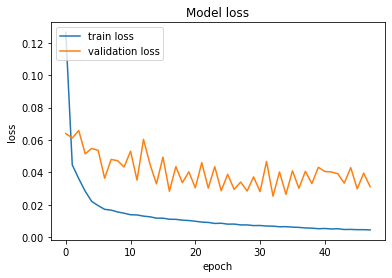

In [11]:
tf.keras.backend.clear_session()

def attention_model():
    inputs = Input(shape=x_train_multi.shape[-2:])

#     x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
#     x = Dropout(0.3)(x)

    lstm_out = Bidirectional(LSTM(100, return_sequences=True))(inputs)
    lstm_out = Bidirectional(LSTM(50, return_sequences=True))(inputs)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)

    #output = Dense(1, activation='sigmoid')(attention_mul)
    #output = Dense(1, activation='linear')(attention_mul)
    output = Dense(20, activation='tanh')(attention_mul)
    output = Dropout(0.2)(output)
    output = Dense(units=horizon)(output)
    model = Model(inputs=[inputs], outputs=output)
    return model

model = attention_model()

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True), 
#                                input_shape=x_train_multi.shape[-2:]),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
#     tf.keras.layers.Dense(20, activation='tanh'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(units=horizon),
# ])

model.compile(optimizer='adam', loss='mse')

folder_save = f"../Results/Attention_LSTM/history_{hist_window}_future_{horizon}_version_{version}"
isExist = os.path.exists(folder_save)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(folder_save)
   print("The new directory is created!")

model_path = f'{folder_save}/model.h5' 

with open(f"{folder_save}/model_config.json", "w") as outfile:
    json.dump(model.get_config(), outfile)

EVALUATION_INTERVAL = 100
EPOCHS = 150
history = model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, 
                         validation_data=val_data_multi, validation_steps=50, verbose=1,
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                     min_delta=0, patience=15, 
                                                                     verbose=1, mode='min'), 
                                    tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                       save_best_only=True,
                                                                       mode='min', verbose=0)])

Trained_model = tf.keras.models.load_model(model_path)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.savefig(f'{folder_save}/history_loss.pdf', bbox_inches='tight')
plt.savefig(f'{folder_save}/history_loss.svg', bbox_inches='tight')
history_loss = [list(a) for a in zip(history.history['loss'], history.history['val_loss'])]
df_loss = pd.DataFrame(history_loss, columns =['loss', 'val_loss']) 
df_loss.to_csv(f'{folder_save}/history_loss.csv')

data_test = x_scaler.fit_transform(valid[column_names].tail(hist_window))
test_rescaled = data_test.reshape(1, data_test.shape[0], data_test.shape[1])

Predicted_results = Trained_model.predict(test_rescaled)
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results.reshape(-1,1))
metrics_test = timeseries_evaluation_metrics_func(test['nat_demand'][:horizon],Predicted_results_Inv_trans)

with open(f"{folder_save}/metrics_test.json", "w") as outfile:
    json.dump(metrics_test, outfile)